In [7]:
import os
import sys
import json
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.optim import lr_scheduler

from opts import parse_opts
from mean import get_mean, get_std
from spatial_transforms import (
    Compose, Normalize, Scale, CenterCrop, CornerCrop, MultiScaleCornerCrop,
    MultiScaleRandomCrop, RandomHorizontalFlip, ToTensor)
from temporal_transforms import LoopPadding, TemporalRandomCrop
from target_transforms import ClassLabel, VideoID
from target_transforms import Compose as TargetCompose
from dataset import get_training_set, get_validation_set, get_test_set
from utils import Logger
from train import train_epoch
from validation import val_epoch
import test
import collections
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from joblib import dump, load
from sklearn import preprocessing
from scipy import stats
from sklearn.metrics import accuracy_score

from models import *

In [8]:
import easydict
opt = easydict.EasyDict({
    "result_path": 'results2',
    "dataset": 'ucf101-music', # 'ucf101',
    "n_classes": 9, 
    "sample_size": 112,
    "sample_duration": 16,
    "initial_scale": 1.0,
    "n_scales": 5,
    "scale_step": 0.84089641525,
    "train_crop": 'corner',
    "learning_rate": 0.1,
    "momentum": 0.9,
    "dampening": 0.9,
    "weight_decay": 0.001,
    "mean_dataset": 'activitynet',
    "no_mean_norm": False,
    "std_norm": False,
    "nesterov": False,
    "optimizer": 'sgd',
    "lr_patience": 10,
    "batch_size": 16,
    "n_epochs": 2,
    "begin_epoch": 1,
    "n_val_samples": 3,
    "ft_begin_index": 5,
    "scale_in_test": 1.0,
    "crop_position_in_test": 'c',
    "no_softmax_in_test": False,
    "no_cuda": False,
    "n_threads": 4,
    "checkpoint": 2,
    "no_hflip": False,
    "norm_value": 1,
    "model": 'resnet',
    "pretained_model_name": 'resnext-101-kinetics',
    "model_depth": 101,
    "resnet_shortcut": 'B',
    "wide_resnet_k": 2,
    "resnext_cardinality": 32,
    "manual_seed": 1,
    'test_subset': 'test',
})
opt.arch = '{}-{}'.format(opt.model, opt.model_depth)
opt.root_path = '/data/qq/CSCE689/video/'
opt.video_path = opt.root_path + 'UCF-music/'
opt.annotation_path = opt.root_path+'UCF-music-annotation/ucf101_music_with_testing.json'

In [9]:
# use two gpu devices on the server, you can customize it depending on how many available gpu devices you have
os.environ['CUDA_VISIBLE_DEVICES']='4'

In [4]:
from models import resnext

# construct model architecture
model = resnext.resnet101(
            num_classes=opt.n_classes,
            shortcut_type=opt.resnet_shortcut,
            cardinality=opt.resnext_cardinality,
            sample_size=opt.sample_size,
            sample_duration=opt.sample_duration)

model = model.cuda()
# wrap the current model again in nn.DataParallel / or we can just remove the .module keys.
model = nn.DataParallel(model, device_ids=None)

# load best weight (we can also refit the model on the combined train-val dataset, 
# but here we simple load the weight and do the final testing)
pretrain = torch.load('./results1/save_200.pth')
model.load_state_dict(pretrain['state_dict'])


/home/qq/CSCE689/3D-ResNets-PyTorch/models/resnext.py:121: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')


<All keys matched successfully>

In [10]:
from datasets.ucf101 import UCF101

mean = get_mean(opt.norm_value, dataset='kinetics')
std = get_std(opt.norm_value)
norm_method = Normalize(mean, [1,1,1])


spatial_transform = Compose([
    Scale(opt.sample_size),
    CornerCrop(opt.sample_size, 'c'),
    ToTensor(opt.norm_value), norm_method
])

temporal_transform = LoopPadding(opt.sample_duration)
target_transform = VideoID() # ClassLabel()



# get test data
test_data = UCF101(
    opt.video_path,
    opt.annotation_path,
    'testing',
    0,
    spatial_transform=spatial_transform,
    temporal_transform=temporal_transform,
    target_transform=target_transform,
    sample_duration=16)


# wrap test data
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=opt.batch_size,
    shuffle=False,
    num_workers=opt.n_threads,
    pin_memory=False)


dataset loading [0/149]


In [6]:
from testing import final_test
test_results, all_output_buffer = final_test(test_loader, model, opt, test_data.class_names)

test


/home/qq/CSCE689/3D-ResNets-PyTorch/testing.py:44: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs = Variable(inputs, volatile=True)
/home/qq/CSCE689/3D-ResNets-PyTorch/testing.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = F.softmax(outputs)


[1/162]	Time 0.922 (0.922)	Data 0.790 (0.790)	
[2/162]	Time 0.116 (0.519)	Data 0.005 (0.397)	
[3/162]	Time 0.098 (0.379)	Data 0.004 (0.266)	
[4/162]	Time 0.094 (0.308)	Data 0.004 (0.201)	
[5/162]	Time 0.245 (0.295)	Data 0.152 (0.191)	
[6/162]	Time 0.096 (0.262)	Data 0.005 (0.160)	
[7/162]	Time 0.096 (0.238)	Data 0.004 (0.138)	
[8/162]	Time 0.096 (0.220)	Data 0.005 (0.121)	
[9/162]	Time 0.318 (0.231)	Data 0.222 (0.132)	
[10/162]	Time 0.095 (0.217)	Data 0.005 (0.120)	
[11/162]	Time 0.098 (0.207)	Data 0.005 (0.109)	
[12/162]	Time 0.097 (0.197)	Data 0.005 (0.100)	
[13/162]	Time 0.352 (0.209)	Data 0.257 (0.113)	
[14/162]	Time 0.097 (0.201)	Data 0.004 (0.105)	
[15/162]	Time 0.096 (0.194)	Data 0.005 (0.098)	
[16/162]	Time 0.095 (0.188)	Data 0.005 (0.092)	
[17/162]	Time 0.329 (0.196)	Data 0.233 (0.101)	
[18/162]	Time 0.094 (0.191)	Data 0.005 (0.095)	
[19/162]	Time 0.096 (0.186)	Data 0.005 (0.090)	
[20/162]	Time 0.096 (0.181)	Data 0.005 (0.086)	
[21/162]	Time 0.279 (0.186)	Data 0.185 (0.091)	
[

In [7]:
examples = ['v_PlayingGuitar_g05_c03', 
            'v_PlayingViolin_g03_c03', 
            'v_PlayingCello_g07_c05', 
            'v_PlayingFlute_g07_c04',
            'v_PlayingPiano_g01_c02']

### Extract clip duration

In [8]:
avi_path = "/data/qq/CSCE689/video/UCF-101"
clip_duration_dict = {}
real_prediction_dict = {}
import os
from moviepy.editor import VideoFileClip
for tvn in test_results['results']:
    clip = VideoFileClip(os.path.join(avi_path, tvn[2:-8], tvn + ".avi"))
    clip_duration_dict[tvn] = [clip.duration, all_output_buffer[tvn]]
    real_prediction_dict[tvn] = test_results['results'][tvn][0]

### Generate prediction plot for each video  (all label)

In [10]:
import matplotlib.pyplot as plt
import numpy as np

for tvn in test_results['results']:
    interval = clip_duration_dict[tvn][0]/len(clip_duration_dict[tvn][1])
    x = np.arange(0, clip_duration_dict[tvn][0], interval) + interval
    y = np.array([np.argmax(pred) for pred in clip_duration_dict[tvn][1]]) + 1  # np.arange(len(test_data.class_names) + 1)
    x = x[:len(y)]
    my_yticks = [''] + list(test_data.class_names.values()) + ['']
    plt.plot(x, y)
    plt.yticks(np.arange(len(my_yticks) + 1), my_yticks)
    plt.xlabel ('time/sec')
    plt.ylabel ('label')
    plt.title("Ground Truth Label:  " + tvn[2:-8]  + "\n Model Avg. Predict:  " + real_prediction_dict[tvn]['label'])
#     plt.savefig("./figs/" + tvn, bbox_inches='tight')
    plt.close()

In [11]:
test_results['results']['v_PlayingTabla_g04_c04']

[{'label': 'PlayingTabla', 'score': 0.5185579657554626},
 {'label': 'PlayingSitar', 'score': 0.14087970554828644},
 {'label': 'PlayingDhol', 'score': 0.1273767501115799},
 {'label': 'PlayingDaf', 'score': 0.11835509538650513},
 {'label': 'PlayingPiano', 'score': 0.04172874987125397},
 {'label': 'PlayingFlute', 'score': 0.025170736014842987},
 {'label': 'PlayingViolin', 'score': 0.014937996864318848},
 {'label': 'PlayingGuitar', 'score': 0.008753728121519089},
 {'label': 'PlayingCello', 'score': 0.004239281173795462}]

### Generate prediction plot for each video (one label)

In [12]:
import matplotlib.pyplot as plt
import numpy as np


# function to return key for any value 
def get_key(val, my_dict): 
    for key, value in my_dict.items(): 
         if val == value: 
            return key 
    return "key doesn't exist"

for tvn in test_results['results']:
    interval = clip_duration_dict[tvn][0]/len(clip_duration_dict[tvn][1])
    x = np.arange(0, clip_duration_dict[tvn][0], interval) + interval
    idx = get_key(tvn[2:-8], test_data.class_names)
    y = np.array([pred[idx] for pred in clip_duration_dict[tvn][1]])  # np.arange(len(test_data.class_names) + 1)    
    x = x[:len(y)]
    plt.plot(x, y)
    plt.xlabel ('time/sec')
    plt.ylabel ('pred score for ground truth label')
    plt.title("Ground Truth Label:  " + tvn[2:-8]  + "\n Model Avg. Predict Score:  " + str(np.mean(y))) # str(real_prediction_dict[tvn]['score'])
#     plt.savefig("./figs2/" + tvn, bbox_inches='tight')
    plt.close()

### Generate json file for each video (one label & all label)

In [13]:
import numpy as np


# function to return key for any value 
def get_key(val, my_dict): 
    for key, value in my_dict.items(): 
         if val == value: 
            return key 
    return "key doesn't exist"

timeTrueLabel = {}
timeAllLabel = {}
for tvn in test_results['results']:
    interval = clip_duration_dict[tvn][0]/len(clip_duration_dict[tvn][1])
    x = np.arange(0, clip_duration_dict[tvn][0], interval) + interval
    idx = get_key(tvn[2:-8], test_data.class_names)
    y1 = np.array([pred[idx] for pred in clip_duration_dict[tvn][1]])  
    y2 = np.array([np.argmax(pred) for pred in clip_duration_dict[tvn][1]])
    x = x[:len(y1)]
    
    timeTrueLabel[tvn] = {tvn[2:-8]: [[str(time), str(y1[idx])] for idx, time in enumerate(x)]}
    timeAllLabel[tvn] = {tvn[2:-8]: [[str(time), test_data.class_names[y2[idx]]] for idx, time in enumerate(x)]}
    

In [22]:
with open('./figs2/timeTrueLabel.json', 'w') as fp:
    json.dump(timeTrueLabel, fp)

with open('./figs/timeAllLabel.json', 'w') as fp:
    json.dump(timeAllLabel, fp)

### Save 5 example json files

In [23]:
import json

with open('./figs2/timeTrueLabel.json', 'r') as fp:
    j1 = json.load(fp)

with open('./figs/timeAllLabel.json', 'r') as fp:
    j2 = json.load(fp)

In [28]:
len(j1), len(j2)

(148, 148)

In [29]:
# fig1 = {}
# fig2 = {}
# for e in examples:
#     fig1[e] = j1[e]
#     fig2[e] = j2[e]
    
# with open('./figs2/fig2.json', 'w') as fp:
#     json.dump(fig1, fp)

# with open('./figs/fig1.json', 'w') as fp:
#     json.dump(fig2, fp)

### Draw the training and validation plots

In [62]:
with open('./results1/train.log', 'r') as file:
    train_log = file.read()
with open('./results1/val.log', 'r') as file:
    val_log = file.read()

In [90]:
train_lines = train_log.split('\n')
val_lines = val_log.split('\n')

In [91]:
train_loss = []
train_acc = []
for train_line in train_lines[1:-1]:
    tmp = train_line.replace('(', ', ')
    tmp = tmp.split(', ')
    train_loss.append(float(tmp[1]))
    train_acc.append(float(tmp[3]))
    
val_loss = []
val_acc = []
for val_line in val_lines[1:-1]:
    tmp = val_line.replace('(', ', ')
    tmp = tmp.split(', ')
    val_loss.append(float(tmp[1]))
    val_acc.append(float(tmp[3]))

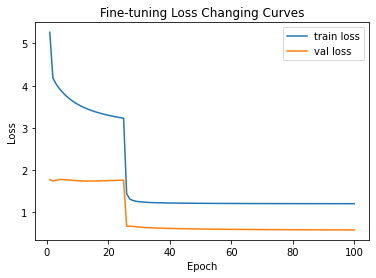

In [99]:
import matplotlib.pyplot as plt
plt.plot(list(range(1, 101)), train_loss, label = "train loss")
plt.plot(list(range(1, 101)), val_loss, label = "val loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
# Set a title of the current axes.
plt.title('Fine-tuning Loss Changing Curves')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

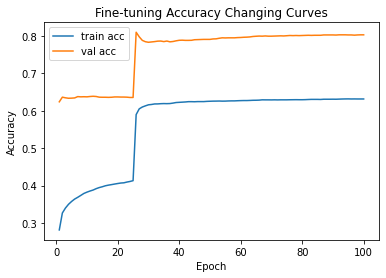

In [101]:
import matplotlib.pyplot as plt
plt.plot(list(range(1, 101)), train_acc, label = "train acc")
plt.plot(list(range(1, 101)), val_acc, label = "val acc")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# Set a title of the current axes.
plt.title('Fine-tuning Accuracy Changing Curves')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

### Test Results

In [2]:
import json
with open('./results1/test.json', 'r') as fp:
    test_results = json.load(fp)

In [6]:
len(test_results['results'].keys())

148

In [14]:
name_to_int = {v:k for k,v in test_data.class_names.items()}
name_to_int

{'PlayingCello': 0,
 'PlayingDaf': 1,
 'PlayingDhol': 2,
 'PlayingFlute': 3,
 'PlayingGuitar': 4,
 'PlayingPiano': 5,
 'PlayingSitar': 6,
 'PlayingTabla': 7,
 'PlayingViolin': 8}

In [23]:
ground_truth = []
predict_label = []
predict_score = []
for k, v in test_results['results'].items():
    ground_truth.append(name_to_int[k[2:-8]])
    predict_label.append(name_to_int[v[0]['label']])
    predict_score.append(v[0]['score'])

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(ground_truth, predict_label, target_names=list(test_data.class_names.values())))

               precision    recall  f1-score   support

 PlayingCello       0.93      0.81      0.87        16
   PlayingDaf       1.00      1.00      1.00        17
  PlayingDhol       0.75      0.86      0.80        21
 PlayingFlute       1.00      0.85      0.92        20
PlayingGuitar       1.00      1.00      1.00        16
 PlayingPiano       0.92      1.00      0.96        12
 PlayingSitar       0.95      1.00      0.98        20
 PlayingTabla       0.80      0.57      0.67        14
PlayingViolin       0.69      0.92      0.79        12

     accuracy                           0.89       148
    macro avg       0.89      0.89      0.89       148
 weighted avg       0.90      0.89      0.89       148



In [42]:
cm = confusion_matrix(ground_truth, predict_label, labels=list(test_data.class_names.keys()))

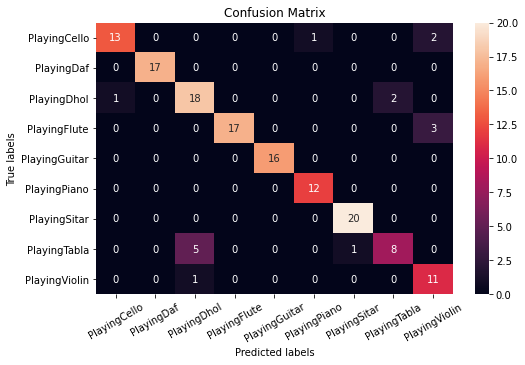

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt     

fig=plt.figure(figsize=(8, 5))

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(list(test_data.class_names.values()), rotation=30); 
ax.yaxis.set_ticklabels(list(test_data.class_names.values()), rotation=0);